# Library instalation
**Files and library uploading**

In [48]:
!pip install -q rdkit mordred


In [49]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import mordred
import numpy as np
from mordred import Calculator, descriptors

import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
#from google.colab import files
#uploaded = files.upload()

# Dataset loading & descriptors calculation

In [51]:
df = pd.read_excel('HILIC_dataset.xlsx', skiprows=2, usecols= [0,1,2])
df.head(4)

,NAME,SMILES,Experimental Retention Time
0,"(2-oxo-2,3-dihydro-1H-indol-3-yl)acetic acid",C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,2.019083
1,"1,1-Dimethyl-4-phenylpiperazinium",CC1C(NC(CN1)C2=CC=CC=C2)C,2.607950
2,"1,2-Cyclohexanediol",C1CCC(C(C1)O)O,4.876550
3,"1,2-Cyclohexanedione",C1CCC(=O)C(=O)C1,5.772267


In [52]:
mol_list = []

for smile in df['SMILES']:
  mol = Chem.MolFromSmiles(smile)
  mol = Chem.AddHs(mol)
  mol_list.append(mol)
df = pd.concat([df, pd.DataFrame(mol_list, columns = (['Mol']))], axis=1)

In [53]:
calc = Calculator(descriptors, ignore_3D=False)
def generate_3d_coordinates(molecule):
    AllChem.EmbedMolecule(molecule)
    AllChem.MMFFOptimizeMolecule(molecule)

descrs = []
for mol in tqdm(df['Mol']):
  generate_3d_coordinates(mol)

# Calculate descriptors
  result = calc(mol)
  descrs.append(result)


final_df = pd.concat([df[['NAME', 'SMILES']], pd.DataFrame(descrs,
                                                           columns = (str(key) for key in result.keys()))],
                      axis=1)

 13%|█▎        | 133/1023 [00:16<02:07,  6.99it/s]c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 1023/1023 [02:51<00:00,  5.95it/s]


**Molecules visualization**

They are 3D so the optimization was sucsessful

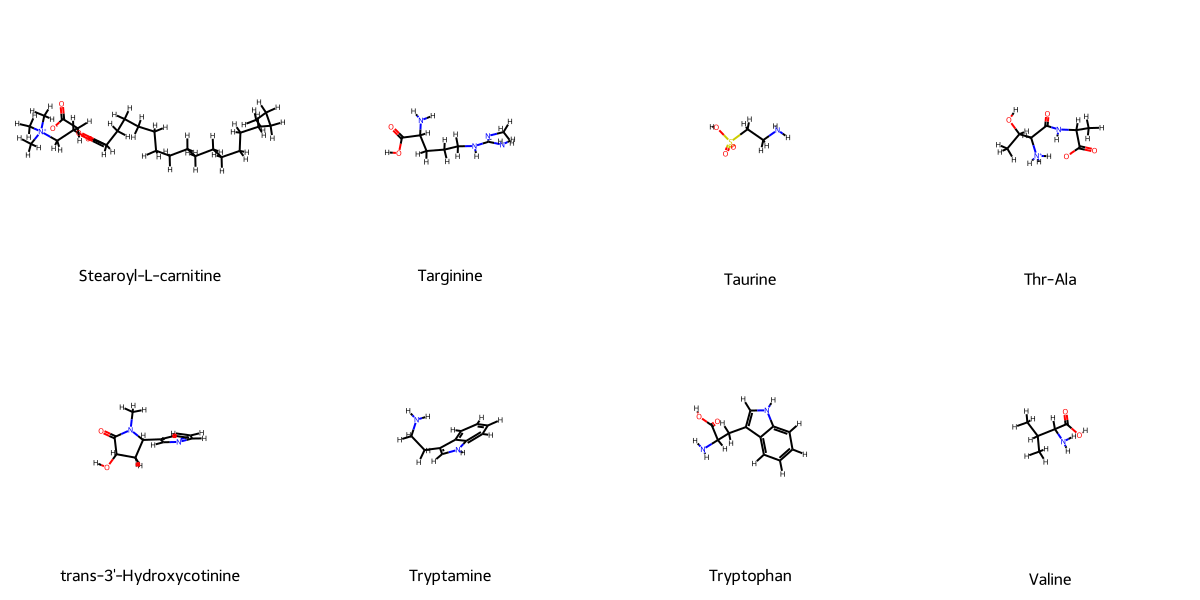

In [54]:
Draw.MolsToGridImage(df['Mol'][-8:], molsPerRow=4, subImgSize=(300,300),
                     legends=[x for x in df['NAME'][-8:]])

**3D+2D descriptors dataframe**


In [55]:
final_df.head()

,NAME,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,"(2-oxo-2,3-dihydro-1H-indol-3-yl)acetic acid",C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,0,17.506132,2.443585,4.706389,17.506132,...,9.497097,60.030351,191.058243,8.306880,287,19,72.0,84.0,5.055556,3.083333
1,"1,1-Dimethyl-4-phenylpiperazinium",CC1C(NC(CN1)C2=CC=CC=C2)C,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,2,18.348875,2.335372,4.670745,18.348875,...,9.398561,45.522055,190.146999,5.942094,303,19,70.0,80.0,4.444444,3.138889
2,"1,2-Cyclohexanediol",C1CCC(C(C1)O)O,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,9.953960,2.193527,4.387054,9.953960,...,8.555837,35.908899,116.083730,5.804186,60,8,36.0,39.0,3.222222,1.861111
3,"1,2-Cyclohexanedione",C1CCC(=O)C(=O)C1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,9.953960,2.193527,4.387054,9.953960,...,8.555837,35.908899,112.052429,7.003277,60,8,36.0,39.0,3.222222,1.861111
4,"1,3,7-Trimethyluric acid",CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,18.656999,2.528281,4.956577,18.656999,...,9.922456,62.252387,210.075290,8.403012,312,28,82.0,102.0,7.138889,3.222222


In [56]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Columns: 1828 entries, NAME to mZagreb2
dtypes: bool(2), float64(964), int64(310), object(552)
memory usage: 14.3+ MB


# EDA
One can see that there are `objects` and `bool` data in the frame. In `mordred`, the `np.float` type was used. Let's change it to `float` type



In [57]:
final_df.head(4).T


,0,1,2,3
NAME,"(2-oxo-2,3-dihydro-1H-indol-3-yl)acetic acid","1,1-Dimethyl-4-phenylpiperazinium","1,2-Cyclohexanediol","1,2-Cyclohexanedione"
SMILES,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,CC1C(NC(CN1)C2=CC=CC=C2)C,C1CCC(C(C1)O)O,C1CCC(=O)C(=O)C1
ABC,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....
ABCGG,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....
nAcid,1,0,0,0
...,...,...,...,...
WPol,19,19,8,8
Zagreb1,72.0,70.0,36.0,36.0
Zagreb2,84.0,80.0,39.0,39.0
mZagreb1,5.055556,4.444444,3.222222,3.222222


In [58]:
obj = final_df.select_dtypes(include=['object', 'bool']).columns.drop(['NAME', 'SMILES'])
final_df[obj] = final_df[obj].astype('float')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Columns: 1828 entries, NAME to mZagreb2
dtypes: float64(1516), int64(310), object(2)
memory usage: 14.3+ MB


As you can see there are only 2 `objects` left. It's NaNs in `ABC` `ABCGG` descriptors collumns. Let's drop them and also drop `SMILES` and `NAME` collumns

In [62]:
final_df_dropped = final_df.drop(['ABC', 'ABCGG','NAME','SMILES'], axis = 1)
final_df_dropped.T.head()

,0,1,2,3,4,5,6,7,8,9,...,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022
nAcid,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
nBase,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,1.000000,1.000000,4.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
SpAbs_A,17.506132,18.348875,9.953960,9.953960,18.656999,9.431148,14.383377,9.924777,17.217679,9.674988,...,12.053348,11.356193,34.740128,15.123934,6.720566,14.256519,18.211815,15.894371,19.078473,8.424292
SpMax_A,2.443585,2.335372,2.193527,2.193527,2.528281,2.175328,2.278414,2.170086,2.496396,2.210509,...,1.918986,2.389175,2.246068,2.102783,2.101003,2.226195,2.423215,2.393832,2.406349,2.135779
SpDiam_A,4.706389,4.670745,4.387054,4.387054,4.956577,4.350655,4.556827,4.340173,4.880450,4.274586,...,3.837972,4.644711,4.492136,4.205566,4.202006,4.452389,4.687077,4.637682,4.673424,4.271558


**3D and 2D descriptors selection**

It is nessecary to separate the 2D descriptors and the 3D descriptors

In [84]:
calc_2d = Calculator(descriptors, ignore_3D=True)
df_2d = calc_2d.pandas(mol_list, quiet=True)  
columns_3d = final_df_dropped.columns.difference(df_2d.columns)
df_3d = final_df_dropped[columns_3d]
df_3d.head()

c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,DPSA1,DPSA2,DPSA3,DPSA4,DPSA5,FNSA1,FNSA2,FNSA3,FNSA4,FNSA5,...,WNSA1,WNSA2,WNSA3,WNSA4,WNSA5,WPSA1,WPSA2,WPSA3,WPSA4,WPSA5
0,2.467579,570.565976,59.581903,24.807216,51.999058,0.496625,-0.775044,-0.109602,-0.033698,-0.086116,...,66.381194,-103.595962,-14.649870,-4.504172,-11.510662,67.283345,105.003879,7.133370,4.565386,7.500277
1,189.414666,425.536297,24.659200,13.298009,25.561230,0.267918,-0.279381,-0.022398,-0.008731,-0.027938,...,44.615727,-46.524511,-3.729836,-1.453891,-4.652451,121.911612,127.127326,6.333031,3.972729,5.778515
2,141.530567,261.212745,33.966178,13.060637,24.821745,0.247763,-0.230685,-0.070222,-0.011534,-0.038447,...,19.501029,-18.156872,-5.527033,-0.907844,-3.026145,59.207482,55.126460,4.002191,2.756323,3.937604
3,67.991537,183.507120,33.875092,11.469195,26.772864,0.375373,-0.252524,-0.099781,-0.015783,-0.063131,...,27.931150,-18.790090,-7.424607,-1.174381,-4.697523,46.477896,31.267021,1.815848,1.954189,2.605585
4,140.051262,704.024538,51.678370,28.160982,58.323181,0.312560,-0.589015,-0.079983,-0.023561,-0.084145,...,43.623747,-82.208360,-11.163169,-3.288334,-11.744051,95.945442,180.807885,8.143332,7.232315,10.044883


2D descriptors frame:

In [ ]:
columns_2d = final_df_dropped.columns.difference(df_3d.columns)
df_2d = final_df_dropped[columns_2d]
df_2d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Columns: 1611 entries, AATS0Z to piPC9
dtypes: float64(1301), int64(310)
memory usage: 12.6 MB


# CorrMatrices

In [90]:
corr_matrix = df_3d.corr()

Text(0.5, 1.0, 'Корреляционная матрица для числовых переменных')

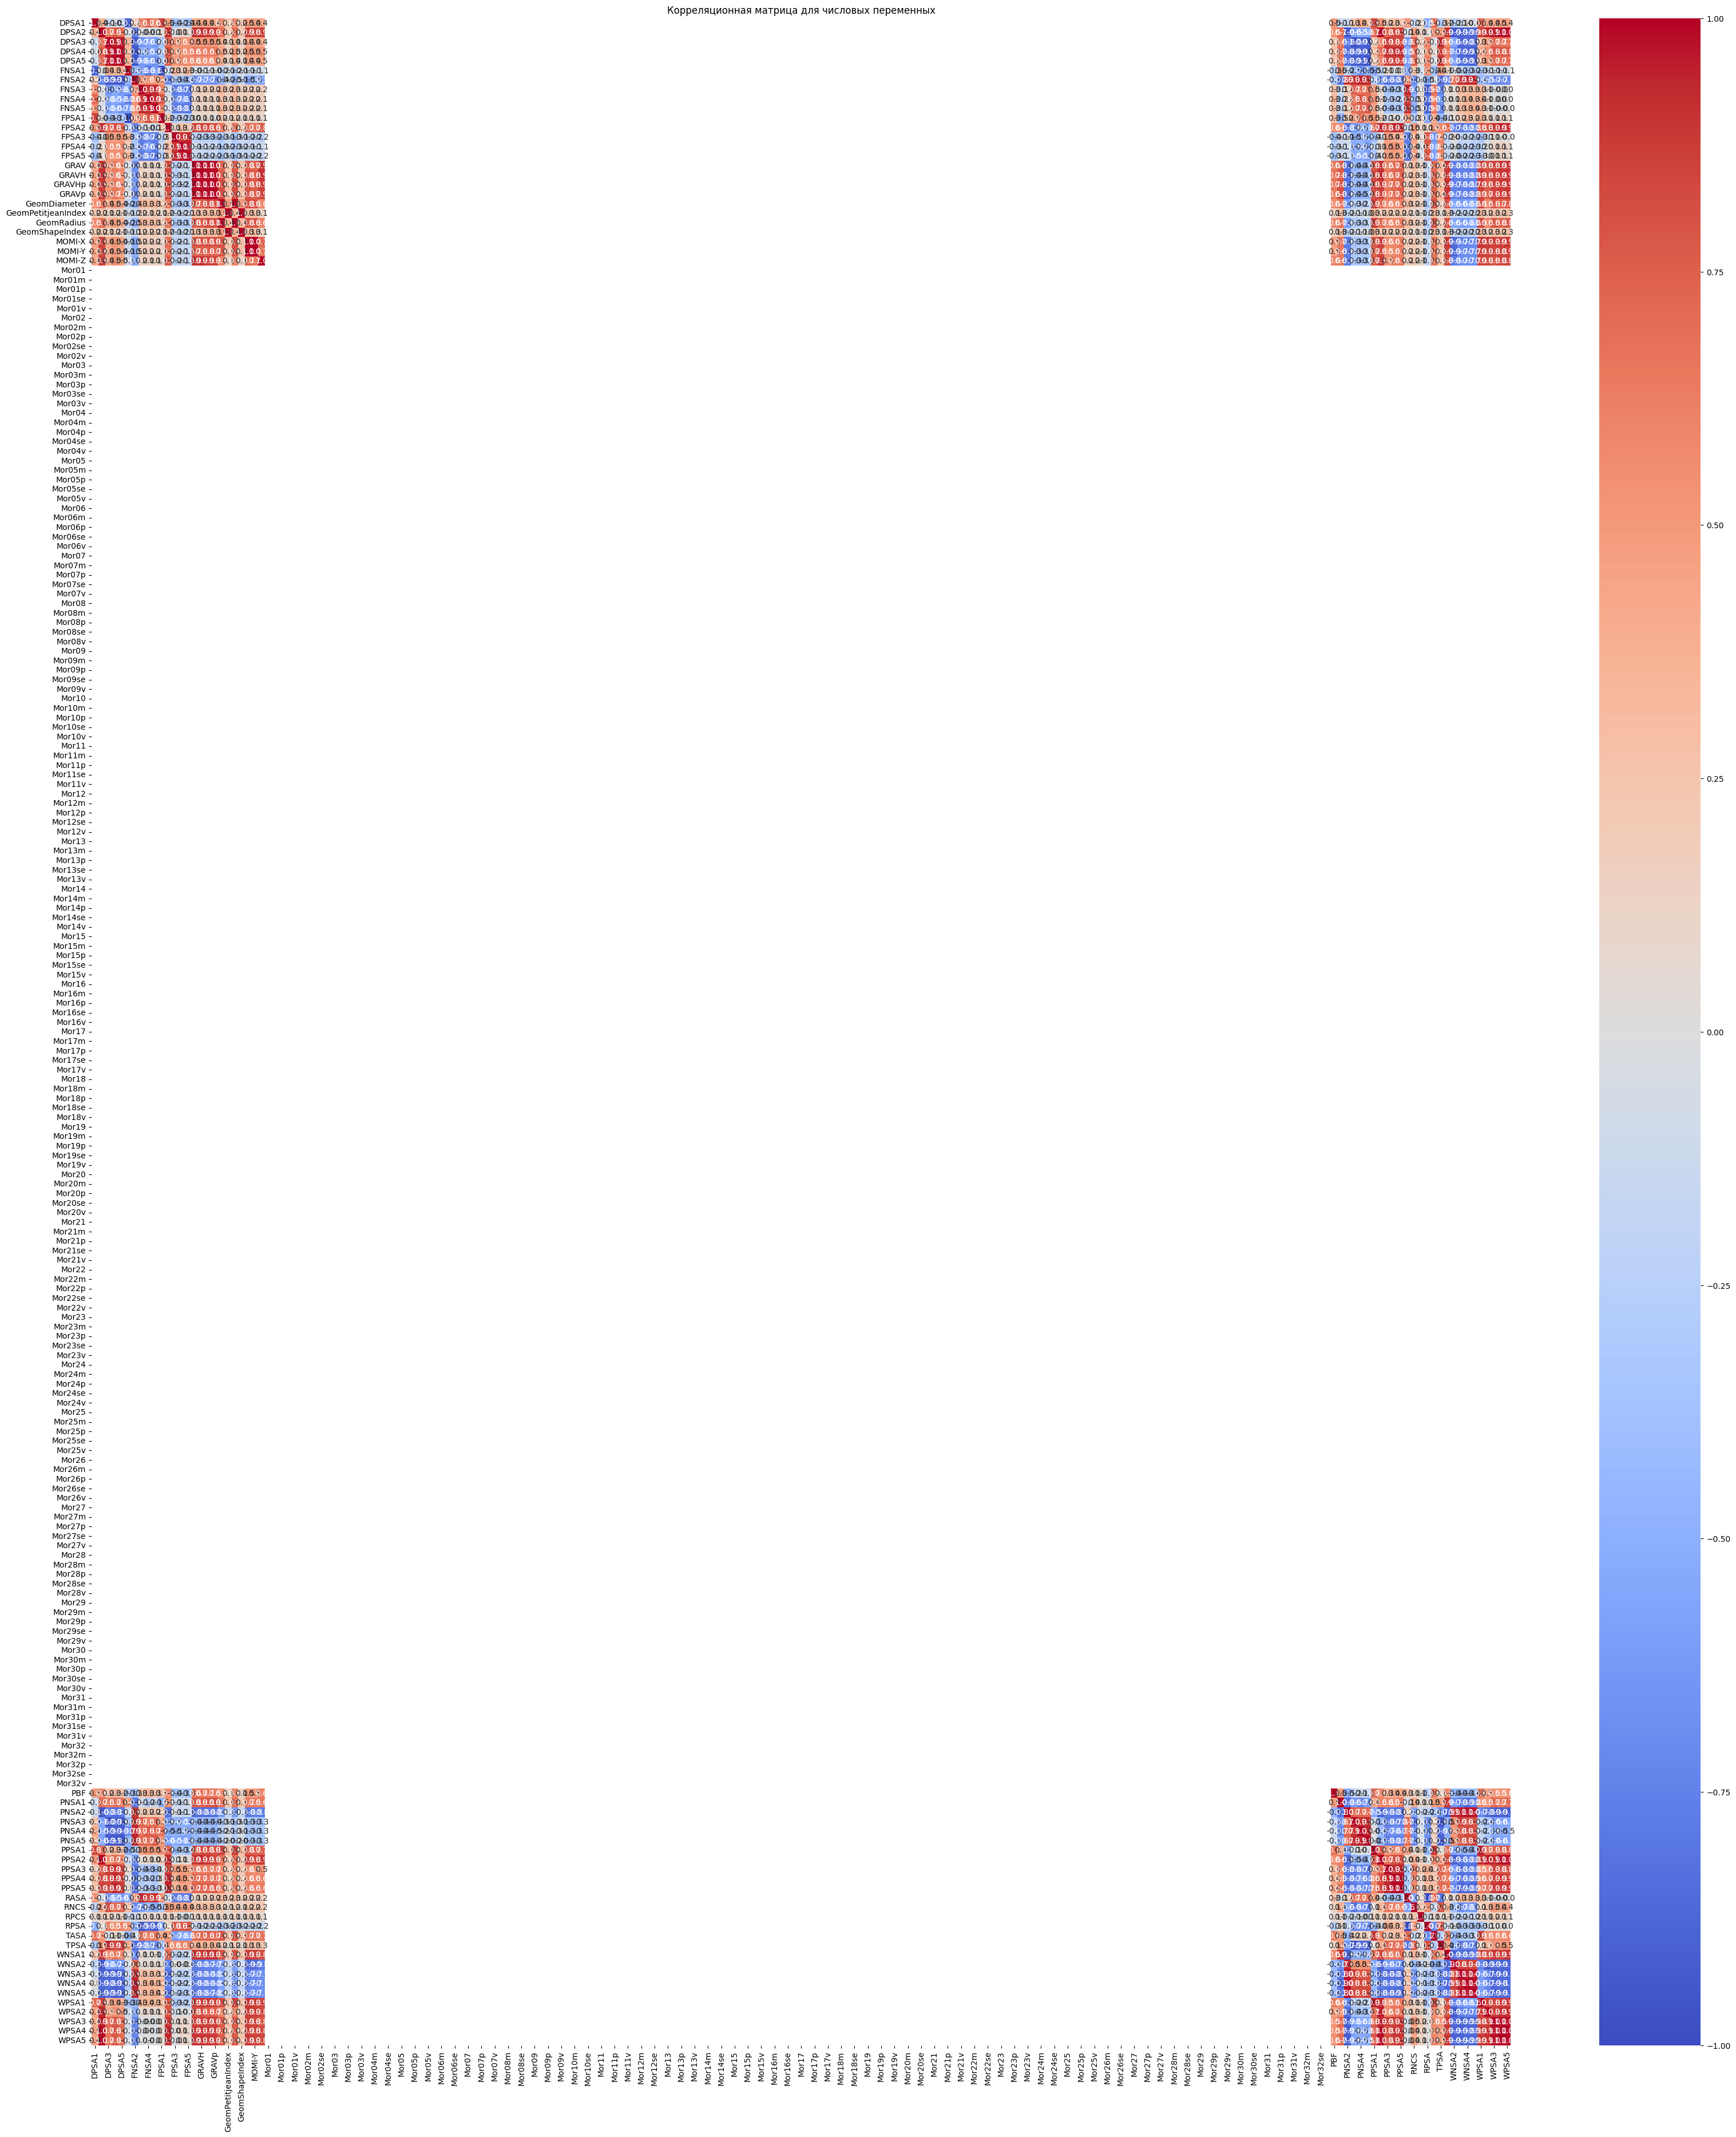

In [94]:
plt.figure(figsize=(40,46))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Корреляционная матрица для числовых переменных")
